In [11]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
from PIL import Image
import matplotlib.patches as patches
import keras
from sklearn.model_selection import train_test_split
import shutil
from shutil import unpack_archive
from subprocess import check_output
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, Adadelta

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import metrics 
from pylab import rcParams
#from sklearn.datasets import make_moons
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

In [5]:
#Transfer learning 
data_directory = '/content/drive/MyDrive/Datasets/lwf_archive/lfw_funneled/'

train_data_lfw_gen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                              shear_range = 0.2,
                                                              zoom_range = 0.2,
                                                              horizontal_flip = True)
test_data_tfw_gen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

lfw_train_set = train_data_lfw_gen.flow_from_directory(data_directory,
                                                       target_size = (110, 110),
                                                       batch_size = 64,
                                                       class_mode = "categorical")
lfw_vali_set = test_data_tfw_gen.flow_from_directory("/content/drive/MyDrive/Datasets/lwf_archive/lfw_kaggle/working/val_multi/",
                                                     target_size = (110, 110),
                                                     batch_size = 64,
                                                     class_mode = "categorical")
 

Found 13233 images belonging to 5749 classes.
Found 72 images belonging to 6 classes.


In [9]:
from sklearn.utils import class_weight
from keras.callbacks import ModelCheckpoint

class_weights = class_weight.compute_class_weight(
                    class_weight = 'balanced',
                    classes = np.unique(lfw_train_set.classes),
                    y = lfw_train_set.classes
                  )
num_classes = 5749
keys = range(num_classes)
values = class_weights.copy()
class_weights = dict(zip(keys, values))
print(class_weights)

{0: 2.301791615933206, 1: 2.301791615933206, 2: 2.301791615933206, 3: 2.301791615933206, 4: 2.301791615933206, 5: 0.5754479039833015, 6: 2.301791615933206, 7: 1.150895807966603, 8: 2.301791615933206, 9: 2.301791615933206, 10: 2.301791615933206, 11: 2.301791615933206, 12: 2.301791615933206, 13: 1.150895807966603, 14: 0.5754479039833015, 15: 2.301791615933206, 16: 2.301791615933206, 17: 2.301791615933206, 18: 0.5754479039833015, 19: 2.301791615933206, 20: 0.12114692715437925, 21: 2.301791615933206, 22: 0.7672638719777353, 23: 1.150895807966603, 24: 2.301791615933206, 25: 0.5754479039833015, 26: 0.7672638719777353, 27: 2.301791615933206, 28: 2.301791615933206, 29: 2.301791615933206, 30: 2.301791615933206, 31: 2.301791615933206, 32: 2.301791615933206, 33: 2.301791615933206, 34: 2.301791615933206, 35: 2.301791615933206, 36: 0.5754479039833015, 37: 1.150895807966603, 38: 0.7672638719777353, 39: 2.301791615933206, 40: 2.301791615933206, 41: 0.7672638719777353, 42: 1.150895807966603, 43: 2.301

In [10]:
base_model = VGG16(
    include_top = False, 
    weights = "imagenet",
    input_shape = (110, 110, 3))
for layer in base_model.layers[:10]:
  layer.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


In [25]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
#model.add(Dropout(0.3))
model.add(Dense(units = 5749, activation = 'softmax'))

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               589952    
                                                                 
 dense_3 (Dense)             (None, 5749)              741621    
                                                                 
Total params: 16,046,261
Trainable params: 14,310,773
Non-trainable params: 1,735,488
_________________________________________________________________


In [27]:
optimizer_3 = SGD(learning_rate=0.01)
model.compile(optimizer = optimizer_3, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [28]:
history = model.fit(lfw_train_set, epochs = 15, verbose = 1, class_weight = class_weights)

Epoch 1/15
207/207 [==============================] - 100s 477ms/step - loss: 8.6698 - accuracy: 2.2671e-04
Epoch 2/15
207/207 [==============================] - 98s 474ms/step - loss: 8.6538 - accuracy: 2.2671e-04
Epoch 3/15
207/207 [==============================] - 99s 477ms/step - loss: 8.6458 - accuracy: 5.2898e-04
Epoch 4/15
207/207 [==============================] - 98s 473ms/step - loss: 8.6265 - accuracy: 6.8012e-04
Epoch 5/15
207/207 [==============================] - 100s 480ms/step - loss: 8.5912 - accuracy: 3.0227e-04
Epoch 6/15
207/207 [==============================] - 99s 475ms/step - loss: 8.5255 - accuracy: 5.2898e-04
Epoch 7/15
207/207 [==============================] - 97s 470ms/step - loss: 8.3950 - accuracy: 9.0682e-04
Epoch 8/15
207/207 [==============================] - 98s 473ms/step - loss: 8.1884 - accuracy: 0.0018
Epoch 9/15
207/207 [==============================] - 97s 466ms/step - loss: 7.8629 - accuracy: 0.0022
Epoch 10/15
207/207 [======================

In [18]:
path = r'/content/drive/MyDrive/Datasets/lwf_archive/lfw_funneled/'

os.chdir(path)

faces = []

with os.scandir(path) as files:
  for file in files:
    name = file.name
    if name.endswith('.txt'):
      continue
    path_2 = os.path.join(path, name)
    os.chdir(path_2)
    with os.scandir(path_2) as files:
      for file2 in files:
        if file2.name.endswith('.jpg'):
          faces.append(file2)


In [19]:
print(len(faces))
print(faces[:10])

13233
[<DirEntry 'Rod_Paige_0001.jpg'>, <DirEntry 'Rod_Thorn_0001.jpg'>, <DirEntry 'Rodrigo_de_la_Cerna_0001.jpg'>, <DirEntry 'Rod_Jong-il_0001.jpg'>, <DirEntry 'Rogelio_Montemayor_0001.jpg'>, <DirEntry 'Rogelio_Ramos_0001.jpg'>, <DirEntry 'Rogerio_Romero_0001.jpg'>, <DirEntry 'Rogerio_Romero_0002.jpg'>, <DirEntry 'Roger_Clemens_0001.jpg'>, <DirEntry 'Roger_Clemens_0002.jpg'>]


In [22]:
from keras.models import Model
model_try = Model(inputs = model.inputs, outputs = model.layers[-2].output)

def CNN_face(file, model):
  img = load_img(file, target_size = (110, 110))

  img = np.array(img)

  reshaped_image = img.reshape(1, 110, 110, 3)

  imgx = preprocess_input(reshaped_image)

  features = model.predict(imgx, use_multiprocessing=True)

  return features

In [30]:
data = {}

for face in faces:
  feat = CNN_face(face, model_try)
  data[face] = feat

filenames = np.array(list(data.keys()))

feat = np.array(list(data.values()))

feat = feat.reshape(-1, 128)

In [32]:
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [33]:
kmeans_3 = KMeans(n_clusters=5, random_state=22)
kmeans_3.fit(x)  

KMeans(n_clusters=5, random_state=22)

In [35]:
groups_3 = {}

for file, cluster in zip(filenames, kmeans_3.labels_):
  if cluster not in groups_3.keys():
    groups_3[cluster] = []
    groups_3[cluster].append(file)
  else:
    groups_3[cluster].append(file)

In [36]:
def view_the_cluster(cluster):
  plt.figure(figsize = (25, 25))
  files = groups_3[cluster]
  if len(files) > 30:
    print(f'Dosya sayısı bu sayıdan {len(files)} to 30')
    files = files[:29]
  for index, file in enumerate(files):
    plt.subplot(10, 10, index + 1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.axis('off')


In [37]:
print(len(groups_3))
for groups in range(len(groups_3)):
  view_the_cluster(groups)

Output hidden; open in https://colab.research.google.com to view.

In [38]:
#find cluster scores
kmeans_score = KMeans(n_clusters = 5, random_state = 22).fit(x)
labels = kmeans_score.labels_
metrics.silhouette_score(x, labels, metric = 'euclidean')

0.065113515

In [39]:
kmeans_per_k = [KMeans(n_clusters = k, random_state = 22).fit(x) for k in range(3, 50)]
silhouette_score_array = [metrics.silhouette_score(x, model.labels_, metric = "euclidean")
                          for model in kmeans_per_k[1:]]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


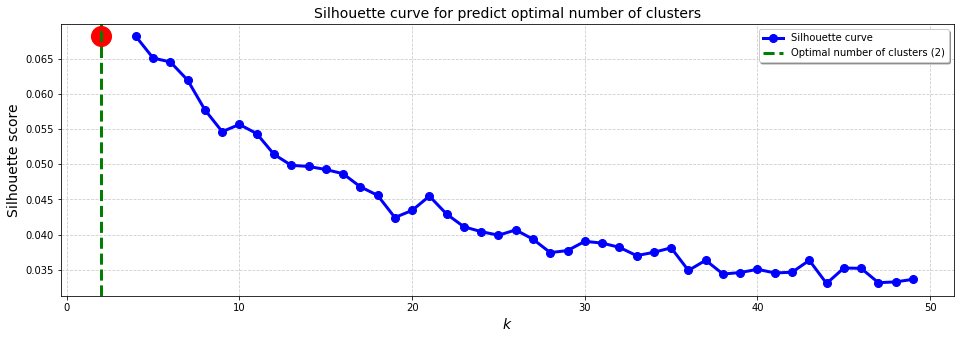

In [40]:
rcParams['figure.figsize'] = 16, 5
_ = plt.plot(range(4, 50), silhouette_score_array, "bo-", color='blue', linewidth = 3, markersize = 8, label = 'Silhouette curve')
_ = plt.xlabel("$k$", fontsize=14, family = "Arial")
_ = plt.ylabel("Silhouette score", fontsize=14, family = "Arial")
_ = plt.grid(which = "major", color = "#cccccc", linestyle = "--")
_ = plt.title("Silhouette curve for predict optimal number of clusters", family = "Arial", fontsize = 14)

k = np.argmax(silhouette_score_array) + 2

_ = plt.axvline(x = k, linestyle = "--", c = "green", linewidth = 3, label = "Optimal number of clusters ({})".format(k))
_ = plt.scatter(k, silhouette_score_array[k - 2], c = 'red', s = 400)
_ = plt.legend(shadow = True)
_ = plt.show()

In [41]:
print('The optimal number of cluster for LFW {}'.format(k))

The optimal number of cluster for LFW 2


In [42]:
#davies bouldin score 
kmeans_score = KMeans(n_clusters = 5, random_state = 22).fit(x)
labels = kmeans_score.labels_
metrics.davies_bouldin_score(x, labels)

2.5079079944397487

In [43]:
#calinski harabasz score
kmeans_score = KMeans(n_clusters = 5, random_state = 22).fit(x)
labels = kmeans_score.labels_
metrics.calinski_harabasz_score(x, labels)

1062.158948986693

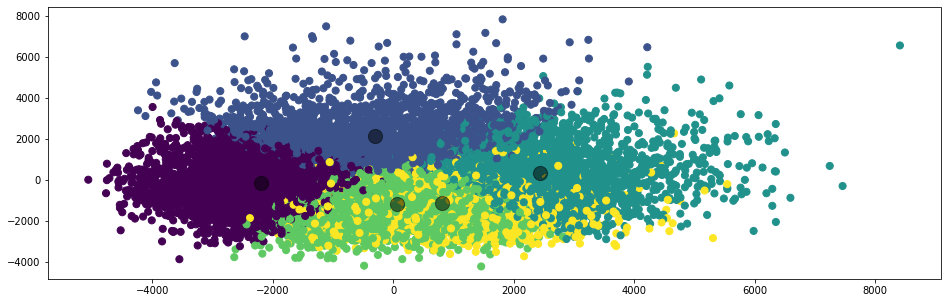

In [44]:
#visualize clusters
kmeans_visual = KMeans(n_clusters = 5, random_state = 22).fit(x)
y_kmeans = kmeans_visual.predict(x)

plt.scatter(x[:, 0], x[:, 1],  c = y_kmeans, s = 50, cmap = 'viridis')

centers = kmeans_visual.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c = 'black', s = 200, alpha = 0.5)

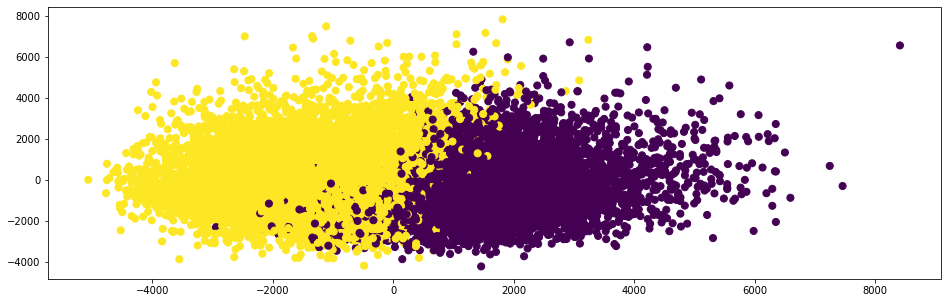

In [45]:
model_spec = SpectralClustering(n_clusters = 2, affinity = 'nearest_neighbors', assign_labels = 'kmeans')
labels = model_spec.fit_predict(x)
plt.scatter(x[:, 0], x[:, 1], c = labels, s = 50, cmap = 'viridis')

In [46]:
k = 5
km = KMeans(n_clusters = k, init = 'k-means++', max_iter = 100, n_init = 5, verbose = 1)
km.fit(x)

Initialization complete
Iteration 0, inertia 320631144448.0
Iteration 1, inertia 202451222528.0
Iteration 2, inertia 195387539456.0
Iteration 3, inertia 194121990144.0
Iteration 4, inertia 193667039232.0
Iteration 5, inertia 193384693760.0
Iteration 6, inertia 193189249024.0
Iteration 7, inertia 193059979264.0
Iteration 8, inertia 192927154176.0
Iteration 9, inertia 192809369600.0
Iteration 10, inertia 192696238080.0
Iteration 11, inertia 192575078400.0
Iteration 12, inertia 192460259328.0
Iteration 13, inertia 192364920832.0
Iteration 14, inertia 192282296320.0
Iteration 15, inertia 192210173952.0
Iteration 16, inertia 192133611520.0
Iteration 17, inertia 192046022656.0
Iteration 18, inertia 191971000320.0
Iteration 19, inertia 191896502272.0
Iteration 20, inertia 191831801856.0
Iteration 21, inertia 191766265856.0
Iteration 22, inertia 191709347840.0
Iteration 23, inertia 191667519488.0
Iteration 24, inertia 191632965632.0
Iteration 25, inertia 191597920256.0
Iteration 26, inertia 19

KMeans(max_iter=100, n_clusters=5, n_init=5, verbose=1)

In [48]:
tfs_reduced = TruncatedSVD(n_components = k, random_state = 0).fit_transform(x)
tfs_embedded = TSNE(n_components = 2, perplexity = 40, verbose = 2).fit_transform(tfs_reduced)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 13233 samples in 0.029s...
[t-SNE] Computed neighbors for 13233 samples in 2.852s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13233
[t-SNE] Computed conditional probabilities for sample 2000 / 13233
[t-SNE] Computed conditional probabilities for sample 3000 / 13233
[t-SNE] Computed conditional probabilities for sample 4000 / 13233
[t-SNE] Computed conditional probabilities for sample 5000 / 13233
[t-SNE] Computed conditional probabilities for sample 6000 / 13233
[t-SNE] Computed conditional probabilities for sample 7000 / 13233
[t-SNE] Computed conditional probabilities for sample 8000 / 13233
[t-SNE] Computed conditional probabilities for sample 9000 / 13233
[t-SNE] Computed conditional probabilities for sample 10000 / 13233
[t-SNE] Computed conditional probabilities for sample 11000 / 13233
[t-SNE] Computed conditional probabilities for sample 12000 / 13233
[t-SNE] Computed conditional probabilities for sa

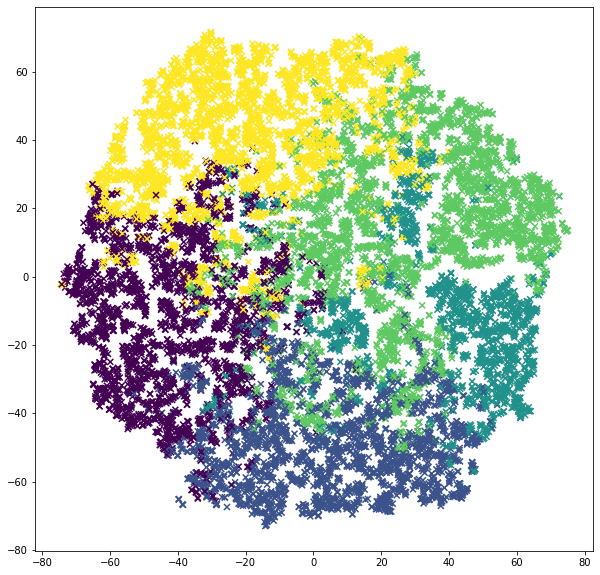

In [50]:
fig = plt.figure(figsize = (10, 10))
ax = plt.axes()
plt.scatter(tfs_embedded[:, 0], tfs_embedded[:,1], marker = 'x', c = km.labels_)
plt.show()